# Predicting Opioid Mortality Rate - In Depth Analysis (Machine Learning)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import warnings
import collections
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from joblib import Parallel, delayed

In [2]:
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
merged_remove = pd.read_csv('merged_remove.csv')

In [4]:
# merged_remove['gq_%_of_total_pop'] = merged_remove['GQ Estimates 2016 (count)'] / \
#                                      merged_remove['Population Estimate 2016 (count)'] * 100

In [5]:
merged_remove['%_pop_chg'] = merged_remove['Population Change 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [6]:
merged_remove.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [7]:
y = merged_remove['Crude Opioid Mortality Rate (per 100,000)']
X = merged_remove.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

# Road Map

1. PCA
3. Multiple Linear Regression
4. Linear Regression with Regularization
    * Ridge Regression
    * LASSO Regression
    * Elastic Net Regression
* CART
6. Random Forest Regression
7. Stochastic Gradient Boosting Regression
    * scikit-learn
    * xgboost

# Principal Component Analysis

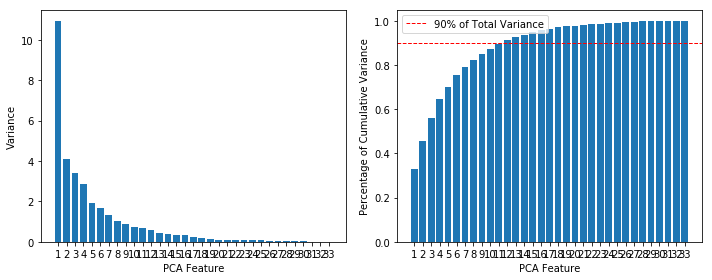

In [8]:
scaler = StandardScaler() # scale data to mean 0 and variance 1

pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

# Plot the explained variances
variance_by_pc = np.array(range(pca.n_components_)) + 1

f, (ax1 ,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

ax1.bar(variance_by_pc, pca.explained_variance_)
ax1.set_xlabel('PCA Feature')
ax1.set_ylabel('Variance')
ax1.set_xticks(ticks = variance_by_pc)

ax2.bar(variance_by_pc, np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('PCA Feature')
ax2.set_ylabel('Percentage of Cumulative Variance')
ax2.set_xticks(ticks = variance_by_pc)
ax2.axhline(y = 0.9, linestyle = 'dashed', linewidth=1, color='r', label = '90% of Total Variance')
ax2.legend()

f.tight_layout()
f.show()

In [9]:
pca_features = pipeline.transform(X)

In [10]:
pca_features.shape

(2962, 33)

In [11]:
%matplotlib inline

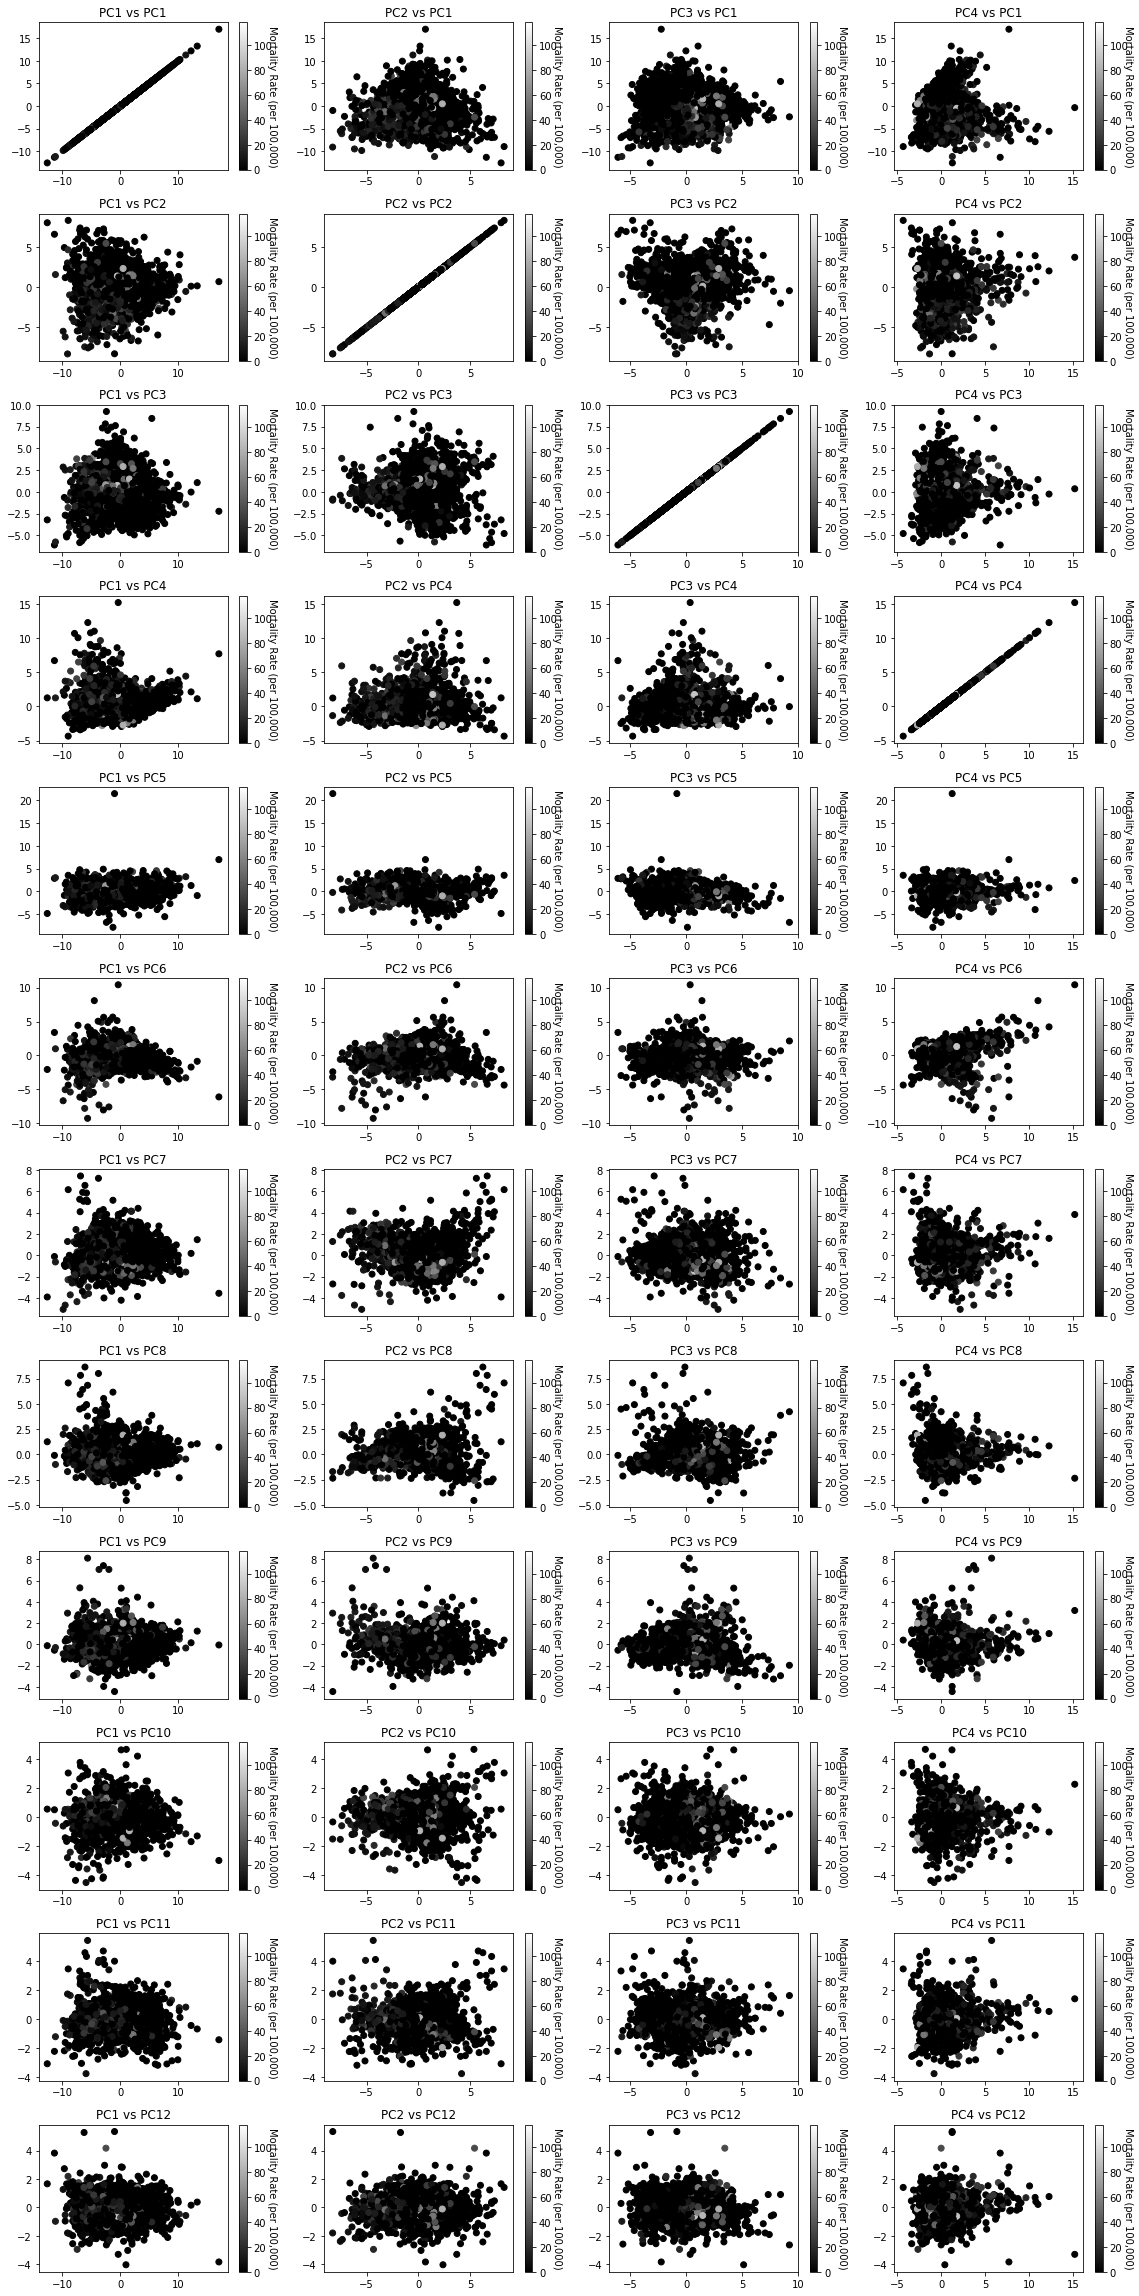

In [12]:
nrows, ncols = 12, 4

f, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (16, 32))

for i, ax in enumerate(axes):
    
    for j in range(ncols):
        
        pos = ax[j].scatter(x = pca_features[:, j], y = pca_features[:, i], c = y, cmap='gray')
        ax[j].set_title('PC{} vs PC{}'.format(j+1,i+1))
        cbar = f.colorbar(mappable = pos, ax = ax[j])
        cbar.set_label('Mortality Rate (per 100,000)', rotation = 270)

f.tight_layout()    
f.show()

In [13]:
# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [14]:
def best_model_generator(fitted_model):
    """From the fitted model, returns the best model
       Also prints best hyperparameter values and test set rmse for fitted model"""
    # Extract the best hyperparameters from 'grid_elastic_net'
    best_hyperparams = fitted_model.best_params_

    print('Best hyperparameters:\n', best_hyperparams)

    # extract best model
    best_model = fitted_model.best_estimator_

    # predict the test set labels
    y_pred = best_model.predict(X_test)

    # Compute rmse_test
    rmse_test_enet = MSE(y_test, y_pred)**0.5

    # Print rmse_test
    print('Test RMSE of best model: {:.3f}'.format(rmse_test_enet)) 
    
    # return best model
    return best_model

In [15]:
# configure bootstrap using parallel for loop
n_iterations = 3
# SEEDS = resample(range(1000), n_samples = n_iterations, random_state = SEED, replace = False)
inputs = range(n_iterations)
n_size = int(len(merged_remove) * 0.80)

def bootstrap_rmse(i, model):
    """Given model, function returns n_iterations of rmse from bootstrap sampling"""
    train = resample(merged_remove, n_samples=n_size)
    test_idx = [index for index in merged_remove.index if index not in train.index]
    test = merged_remove.iloc[merged_remove.index.isin(test_idx), :]
    # define X_train, y_train, X_test, y_test
    X_train = train.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_train = train['Crude Opioid Mortality Rate (per 100,000)']
    X_test = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_test = test['Crude Opioid Mortality Rate (per 100,000)']

    model.fit(X_train, y_train)
    # evaluate model
    predictions = model.predict(X_test)
    rmse = MSE(y_test, predictions)**0.5
    return rmse

In [16]:
def plot_bootstrap_histogram(bootstrap_distribution, plot_label):
    """plots bootstrap histogram from bootstrap sampling and also prints 95% bootstrap CI values"""
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    sns.distplot(bootstrap_distribution, kde=False, rug=True, ax = ax)
    ax.set_title('Bootstrap Distribution of RMSE\n{}'.format(plot_label))
    fig.show()

In [17]:
def feature_importance_plot(model, plot_label):
    """Input is a model and plot label
       Output is a feature importance horizontal bar plot"""
    # create a pd.Series of features importances
    feature_importances = pd.Series(model.feature_importances_, index = X.columns)

    # sort feature_importances
    sorted_importances = feature_importances.sort_values()

    # make a horizontal bar plot
    f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 12))
    sorted_importances.plot(kind = 'barh', color = 'lightgreen', ax=ax)
    ax.set_title('Feature Importance Based on {}'.format(plot_label))
    f.show()

# Multiple Linear Regression

In [18]:
# Multiple Linear Regression

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('linear', LinearRegression())]

linear_pipeline = Pipeline(steps)

# fit to the training data
linear_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lr = linear_pipeline.predict(X_test)

# Compute rmse_test
rmse_test = MSE(y_test, y_pred_lr)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Test RMSE of best model: 8.530


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


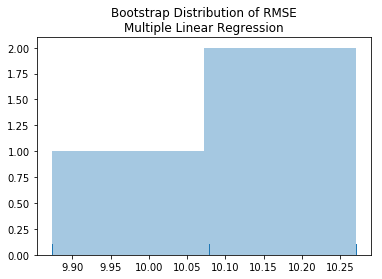

In [19]:
bootstrap_rmse_lr = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, linear_pipeline) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_lr, plot_label = 'Multiple Linear Regression')

# Ridge Regression

## No hyperparameter tuning

In [20]:
# Ridge (no hyperparameter tuning)# Ridge  

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

ridge_pipeline = Pipeline(steps)

# fit to the training data
ridge_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_ridge = ridge_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_ridge = MSE(y_test, y_pred_ridge)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_ridge))

Test RMSE of best model: 8.515


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


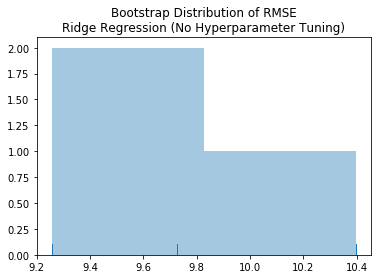

In [21]:
bootstrap_rmse_ridge_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, ridge_pipeline)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_ridge_default,\
                         plot_label = 'Ridge Regression (No Hyperparameter Tuning)')

# Ridge Regression

## Hyperparameter Tuning

In [22]:
# Ridge (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
ridge_pipeline = Pipeline(steps)

ridge_param_grid = dict(ridge__alpha= np.logspace(-10, 0, 500),
                        ridge__fit_intercept= [True, False])

ridge_randomized_neg_mse = RandomizedSearchCV(estimator = ridge_pipeline, 
                                 param_distributions = ridge_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_ridge' to the training data
ridge_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123, solver='auto', tol=0.001))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'ridge__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'ridge__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best hyperparameters:
 {'ridge__fit_intercept': True, 'ridge__alpha': 5.265539630332755e-10}
Test RMSE of best model: 8.519


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


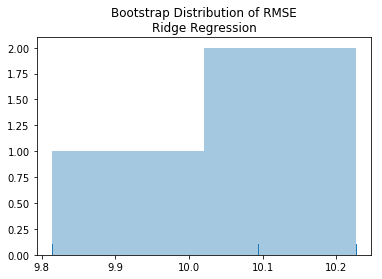

In [23]:
best_model_ridge = best_model_generator(fitted_model = ridge_randomized_neg_mse)

bootstrap_rmse_ridge = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_ridge) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_ridge, plot_label = 'Ridge Regression')

# LASSO Regression
## No Hyperparameter Tuning

In [24]:
# LASSO (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

lasso_pipeline = Pipeline(steps)

# fit to the training data
lasso_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lasso = lasso_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_lasso = MSE(y_test, y_pred_lasso)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_lasso))

Test RMSE of best model: 9.024


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


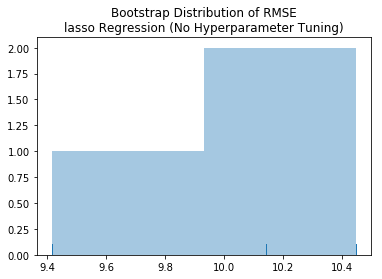

In [25]:
bootstrap_rmse_lasso_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, lasso_pipeline)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_lasso_default, plot_label = 'lasso Regression (No Hyperparameter Tuning)')

# LASSO Regression

## Hyperparameter Tuning

In [26]:
# LASSO (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
lasso_pipeline = Pipeline(steps)

lasso_param_grid = dict(lasso__alpha= np.logspace(-10, 0, 500),
                        lasso__fit_intercept= [True, False])

lasso_randomized_neg_mse = RandomizedSearchCV(estimator = lasso_pipeline, 
                                 param_distributions = lasso_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_lasso' to the training data
lasso_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'lasso__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'lasso__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Best hyperparameters:
 {'lasso__fit_intercept': True, 'lasso__alpha': 0.8707224849239904}
Test RMSE of best model: 8.945


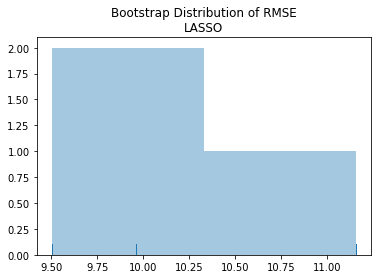

In [27]:
best_model_lasso = best_model_generator(fitted_model = lasso_randomized_neg_mse)

bootstrap_rmse_lasso = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_lasso) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_lasso, plot_label = 'LASSO')

# Elastic Net Regression
## No Hyperparameter Tuning

In [28]:
# Elastic Net (no hyperparameter tuning)# Elasti 

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('elastic_net', ElasticNet(random_state = SEED))]

elastic_net_pipeline = Pipeline(steps)

# fit to the training data
elastic_net_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_enet = elastic_net_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_enet = MSE(y_test, y_pred_enet)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_enet))

Test RMSE of best model: 8.859


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


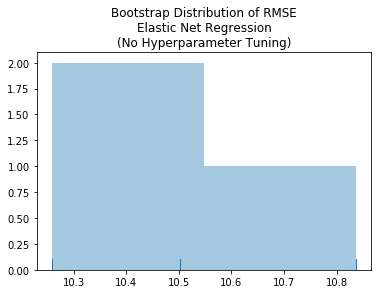

In [29]:
bootstrap_rmse_enet_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, elastic_net_pipeline)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_enet_default, plot_label = 'Elastic Net Regression\n(No Hyperparameter Tuning)')

# Elastic Net

## Hyperparameter Tuning

In [30]:
# Elastic Net (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('elastic_net', ElasticNet(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
elastic_net_pipeline = Pipeline(steps)

elastic_net_param_grid = dict(elastic_net__alpha= np.logspace(-10, 0, 500),
                              elastic_net__l1_ratio = np.arange(0, 1, 0.01),
                              elastic_net__fit_intercept= [True, False])

elastic_net_randomized_neg_mse = RandomizedSearchCV(estimator = elastic_net_pipeline, 
                                 param_distributions = elastic_net_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_elastic_net' to the training data
elastic_net_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic_net', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123, selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'elastic_net__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'elastic_net__l1_ratio': array([0.  , 0.01, ..., 0.98, 0.99]), 'elastic_net__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best hyperparameters:
 {'elastic_net__l1_ratio': 0.08, 'elastic_net__fit_intercept': True, 'elastic_net__alpha': 2.4591304254680416e-05}
Test RMSE of best model: 8.519


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


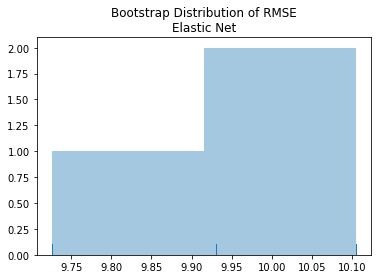

In [31]:
best_model_enet = best_model_generator(fitted_model = elastic_net_randomized_neg_mse)

bootstrap_rmse_enet = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_enet) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_enet, plot_label = 'Elastic Net')

# Classification and Regressor Tree (CART)
## No Hyperparameter Tuning

In [32]:
# CART (no hyperparameter tuning)

# Instantiate dt
dt = DecisionTreeRegressor(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred_dt = dt.predict(X_test)

# Compute MSE
rmse_test_dt = MSE(y_test, y_pred_dt) ** 0.5

# Print RMSE
print('Test set RMSE of dt: {:.3f}'.format(rmse_test_dt))

Test set RMSE of dt: 13.305


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


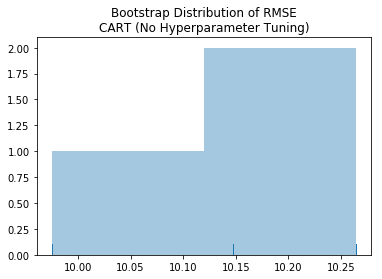

In [33]:
bootstrap_rmse_dt_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, elastic_net_pipeline)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_dt_default, plot_label = 'CART (No Hyperparameter Tuning)')

# Classification and Regressor Tree (CART)

## Hyperparameter Tuning

In [34]:
# CART (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('dt', DecisionTreeRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
dt_pipeline = Pipeline(steps)

dt_param_grid = dict(dt__max_depth= np.arange(1, 50, 10),
                     dt__min_samples_split= np.arange(2, 50, 2),
                     dt__min_samples_leaf= np.arange(1, 100, 2))

dt_randomized_neg_mse = RandomizedSearchCV(estimator = dt_pipeline, 
                                 param_distributions = dt_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_dt' to the training data
dt_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best'))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'dt__max_depth': array([ 1, 11, 21, 31, 41]), 'dt__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]), 'dt__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
          pre_dispatch='2*n_jobs', random_state=None, ref

Best hyperparameters:
 {'dt__min_samples_split': 6, 'dt__min_samples_leaf': 65, 'dt__max_depth': 11}
Test RMSE of best model: 8.336


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


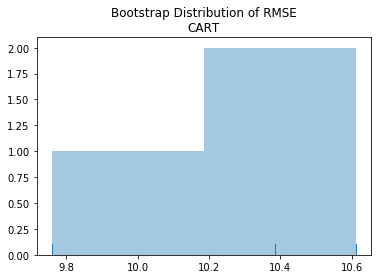

In [35]:
best_model_dt = best_model_generator(fitted_model = dt_randomized_neg_mse)

bootstrap_rmse_dt = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_dt) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_dt, plot_label = 'CART')

# Random Forest Regressor
## No Hyperparameter Tuning

In [36]:
#  random forest (no hyperparameter tuning)

# Instantiate rf
rf = RandomForestRegressor(random_state=SEED)

# Fit rf to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred_rf = rf.predict(X_test)

# Compute RMSE
rmse_test_rf = MSE(y_test, y_pred_rf)**0.5

# Print RMSE
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_rf))

Test set RMSE of rf: 8.633


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


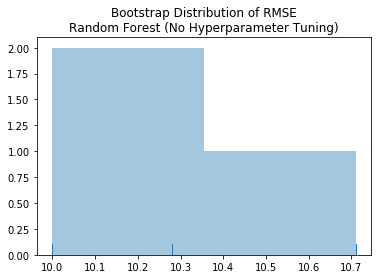

In [37]:
bootstrap_rmse_rf_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, rf)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_rf_default, plot_label = 'Random Forest (No Hyperparameter Tuning)')

# Random Forest Regressor

## Hyperparameter Tuning

In [38]:
# RandomForest (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('rf', RandomForestRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
rf_pipeline = Pipeline(steps)

rf_param_grid = dict(rf__n_estimators = np.arange(2, 500, 10),
                     rf__max_depth= np.arange(1, 50, 10),
                     rf__max_features= np.arange(0.05, 1, 0.05),
                     rf__min_samples_split= np.arange(2, 50, 2),
                     rf__min_samples_leaf= np.arange(1, 100, 2),
                     rf__bootstrap= [True, False])

rf_randomized_neg_mse = RandomizedSearchCV(estimator = rf_pipeline, 
                                 param_distributions = rf_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_rf' to the training data
rf_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'rf__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4...   69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]), 'rf__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs',

Best hyperparameters:
 {'rf__n_estimators': 22, 'rf__min_samples_split': 32, 'rf__min_samples_leaf': 9, 'rf__max_features': 0.15000000000000002, 'rf__max_depth': 41, 'rf__bootstrap': False}
Test RMSE of best model: 7.755


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


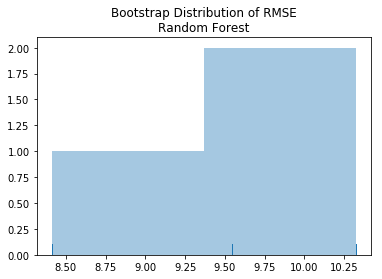

In [39]:
best_model_rf = best_model_generator(fitted_model = rf_randomized_neg_mse)

bootstrap_rmse_rf = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_rf) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_rf, plot_label = 'Random Forest')

# Feature Importance Based on Random Forest Best Model

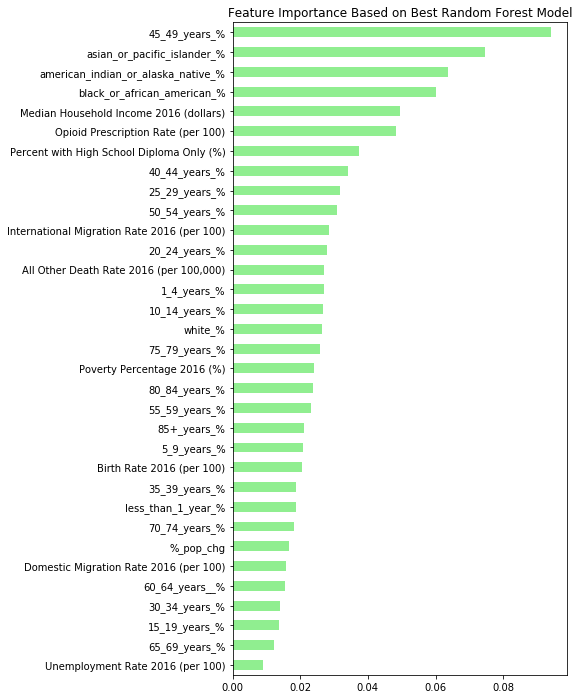

In [40]:
feature_importance_plot(best_model_rf.steps[0][1], 'Best Random Forest Model')

# Gradient Boosting Regressor

## No Hyperparameter Tuning

In [41]:
#  gradient boosting using scikit-learn (no hyperparameter tuning)

# Instantiate gb
gb = GradientBoostingRegressor(random_state=SEED)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred_gb = gb.predict(X_test)

# Compute RMSE
rmse_test_gb = MSE(y_test, y_pred_gb)**0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test_gb))

Test set RMSE of gb: 7.662


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


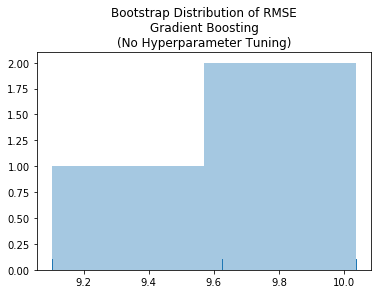

In [42]:
bootstrap_rmse_gb_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, gb)\
                                                                                 for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_gb_default,\
                         plot_label = 'Gradient Boosting\n(No Hyperparameter Tuning)')

# Gradient Boosting Regressor

## Hyperparameter Tuning

In [43]:
# gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('gb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
gb_pipeline = Pipeline(steps)

gb_param_grid = dict(gb__n_estimators = np.arange(2, 500, 10),
                      gb__max_depth= np.arange(1, 50, 10),
                      gb__min_samples_split= np.arange(2, 50, 2),
                      gb__min_samples_leaf= np.arange(1, 100, 2),
                      gb__learning_rate = np.arange(0.05, 1, 0.05))

gb_randomized_neg_mse = RandomizedSearchCV(estimator = gb_pipeline, 
                                            param_distributions = gb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = 3,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_gb' to the training data
gb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, m...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'gb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,


Best hyperparameters:
 {'gb__n_estimators': 422, 'gb__min_samples_split': 10, 'gb__min_samples_leaf': 21, 'gb__max_depth': 11, 'gb__learning_rate': 0.45}
Test RMSE of best model: 9.157


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished


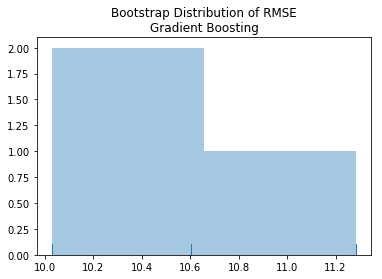

In [44]:
best_model_gb = best_model_generator(fitted_model = gb_randomized_neg_mse)

bootstrap_rmse_gb = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_gb) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_gb, plot_label = 'Gradient Boosting')

# Stochastic Gradient Boosting Regressor (scikit-learn)

## No Hyperparameter Tuning

In [45]:
# stochastic gradient boosting regressor using scikit-learn (no parameter tuning)

# Instantiate sgbr
sgbr = GradientBoostingRegressor(subsample=0.9,
            max_features=0.75,
            random_state=SEED)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_sgbr = sgbr.predict(X_test)

# Compute test set RMSE
rmse_test_sgbr = MSE(y_test, y_pred_sgbr)**0.5


# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test_sgbr))

Test set RMSE of sgbr: 7.704


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


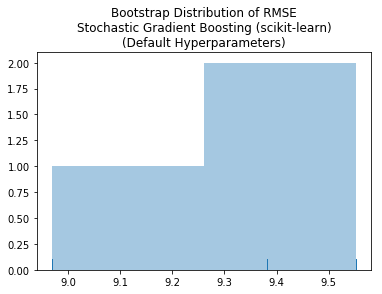

In [46]:
bootstrap_rmse_sgbr_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, sgbr) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_sgbr_default,\
                         plot_label = 'Stochastic Gradient Boosting (scikit-learn)\n(Default Hyperparameters)')

# Stochastic Gradient Boosting Regressor (scikit-learn)

## Hyperparameter Tuning

In [47]:
# stochastic gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('sgb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
sgb_pipeline = Pipeline(steps)

sgb_param_grid = dict(sgb__n_estimators = np.arange(2, 500, 10),
                      sgb__max_depth= np.arange(1, 50, 10),
                      sgb__max_features= np.arange(0.05, 1, 0.05),
                      sgb__min_samples_split= np.arange(2, 50, 2),
                      sgb__min_samples_leaf= np.arange(1, 100, 2),
                      sgb__subsample= np.arange(0.05, 1, 0.05),
                      sgb__learning_rate = np.arange(0.05, 1, 0.05))

sgb_randomized_neg_mse = RandomizedSearchCV(estimator = sgb_pipeline, 
                                            param_distributions = sgb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = 3,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_sgb' to the training data
sgb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.4s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('sgb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, ...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'sgb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, ..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,


Best hyperparameters:
 {'sgb__subsample': 0.8500000000000001, 'sgb__n_estimators': 442, 'sgb__min_samples_split': 38, 'sgb__min_samples_leaf': 85, 'sgb__max_features': 0.25, 'sgb__max_depth': 21, 'sgb__learning_rate': 0.15000000000000002}
Test RMSE of best model: 8.661


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


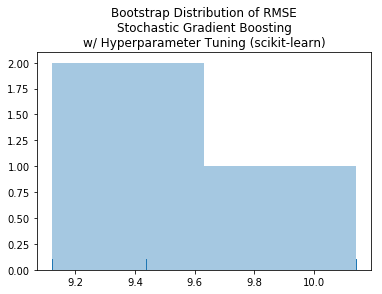

In [48]:
best_model_sgb = best_model_generator(fitted_model = sgb_randomized_neg_mse)

bootstrap_rmse_sgb = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_sgb) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_sgb, 
                         plot_label = 'Stochastic Gradient Boosting\nw/ Hyperparameter Tuning (scikit-learn)')

# Stochastic Gradient Boosting Regressor (xgboost)

## No Hyperparameter Tuning

In [49]:
# stochastic gradient boosting regressor using xgboost (no parameter tuning)

# Instantiate xgbr
xgbr = xgb.XGBRegressor(subsample=0.9,
            colsample_bytree=0.75,
            random_state=SEED)

# Fit xgbr to the training set
xgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_xgbr = xgbr.predict(X_test)

# Compute test set RMSE
rmse_test_xgbr = MSE(y_test, y_pred_xgbr)**0.5

# Print rmse_test
print('Test set RMSE of xgbr: {:.3f}'.format(rmse_test_xgbr))

Test set RMSE of xgbr: 7.735


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


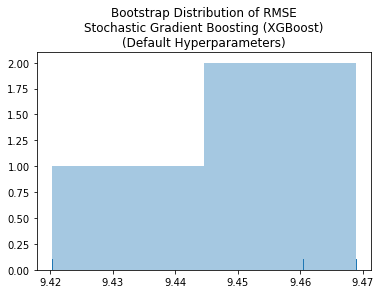

In [50]:
bootstrap_rmse_xgbr_default = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, xgbr) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_xgbr_default,\
                         plot_label = 'Stochastic Gradient Boosting (XGBoost)\n(Default Hyperparameters)')

# Feature Importance Based on XGBoost

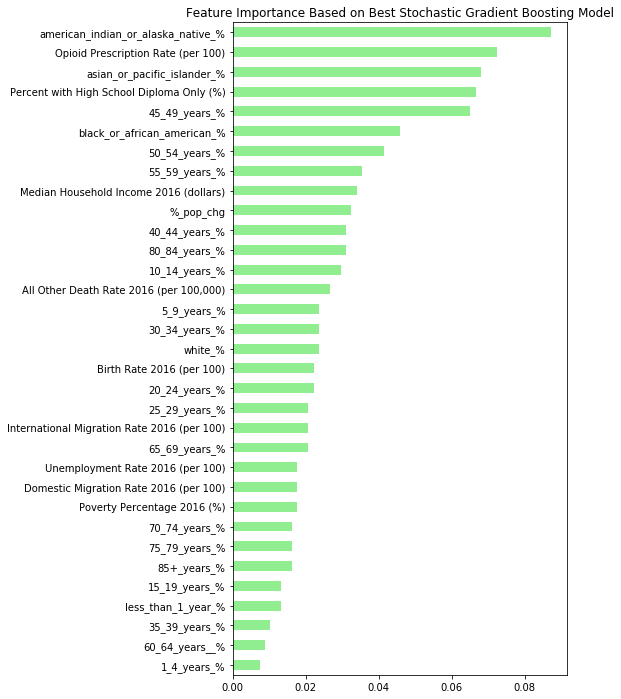

In [51]:
feature_importance_plot(xgbr, 'Best Stochastic Gradient Boosting Model')

# Stochastic Gradient Boosting Regressor (xgboost)

## Hyperparameter Tuning

In [52]:
# Stochastic Gradient Boosting Regressor using xgbroost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 verbose = 1,
                                 n_jobs = -1)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('xgbr', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid=True, n_iter=3, n_jobs=-1,
          param_distributions={'xgbr__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452,..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jo

In [53]:
best_model_xgbr = best_model_generator(fitted_model = xgbr_randomized_neg_mse)

Best hyperparameters:
 {'xgbr__subsample': 0.55, 'xgbr__n_estimators': 452, 'xgbr__max_depth': 49, 'xgbr__learning_rate': 0.15000000000000002, 'xgbr__colsample_bytree': 0.7000000000000001}
Test RMSE of best model: 8.676


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.2s finished


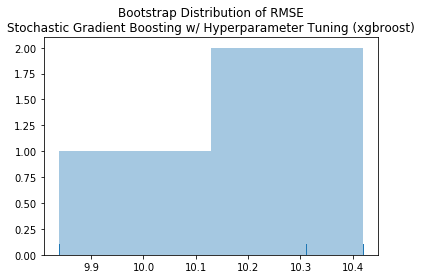

In [54]:
bootstrap_rmse_xgbr = Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse)(i, best_model_xgbr) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_xgbr, plot_label = 'Stochastic Gradient Boosting w/ Hyperparameter Tuning (xgbroost)')

# Hurdle Approach

In [55]:
merged_remove_hurdle = pd.read_csv('merged_remove.csv')

merged_remove_hurdle['classification'] = np.where(merged_remove_hurdle['Crude Opioid Mortality Rate (per 100,000)'] == 0, 0, 1)

In [56]:
# merged_remove_hurdle['gq_%_of_total_pop'] = merged_remove_hurdle['GQ Estimates 2016 (count)'] / \
#                                      merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

In [57]:
merged_remove_hurdle['%_pop_chg'] = merged_remove_hurdle['Population Change 2016 (count)'] / \
                                     merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

In [58]:
merged_remove_hurdle.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [59]:
y_hurdle = merged_remove_hurdle['classification']
X_hurdle = merged_remove_hurdle.drop(columns = 'classification')

In [60]:
# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train_hurdle, X_test_hurdle, y_train_hurdle_clf, y_test_hurdle_clf = train_test_split(X_hurdle, y_hurdle, 
                                                            test_size = 0.2, stratify = y_hurdle, random_state = SEED)

X_train_hurdle_clf = X_train_hurdle.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

X_test_hurdle_clf = X_test_hurdle.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

In [61]:
# Stochastic Gradient Boosting Classifier using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbc', xgb.XGBClassifier(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbc_pipeline = Pipeline(steps)

xgbc_param_grid = dict(xgbc__n_estimators = np.arange(2, 500, 10),
                      xgbc__max_depth= np.arange(1, 50, 1),
                      xgbc__subsample= np.arange(0.05, 1, 0.05),
                      xgbc__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbc__learning_rate = np.arange(0.05, 1, 0.05))

xgbc_randomized_recall = RandomizedSearchCV(estimator = xgbc_pipeline, 
                                 param_distributions = xgbc_param_grid, 
                                 scoring = 'recall', 
                                 cv = 5,
                                 n_iter = 3,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'xgbc_randomized_recall' to the training data
xgbc_randomized_recall.fit(X_train_hurdle_clf, y_train_hurdle_clf)

# Extract the best hyperparameters from 'grid_xgbc'
best_hyperparams_clf = xgbc_randomized_recall.best_params_

print('Best hyperparameters:\n', best_hyperparams_clf)

# extract best model from 'grid_xgbc'
xgbc_best_model = xgbc_randomized_recall.best_estimator_

recall_score(y_test_hurdle_clf, xgbc_best_model.predict(X_test_hurdle_clf))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.3s finished


Best hyperparameters:
 {'xgbc__subsample': 0.4, 'xgbc__n_estimators': 302, 'xgbc__max_depth': 9, 'xgbc__learning_rate': 0.8, 'xgbc__colsample_bytree': 0.5}


0.6785714285714286

In [62]:
predictions_best_model_train = xgbc_best_model.predict(X_train_hurdle_clf)

X_train_hurdle_true_predict = X_train_hurdle[predictions_best_model_train == 1]

X_train_hurdle_reg = X_train_hurdle_true_predict.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

y_train_hurdle_reg = X_train_hurdle_true_predict['Crude Opioid Mortality Rate (per 100,000)']

In [63]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 3,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train_hurdle_reg, y_train_hurdle_reg)

# Extract the best hyperparameters from 'grid_xgbr'
best_hyperparams_reg = xgbr_randomized_neg_mse.best_params_

print('Best hyperparameters:\n', best_hyperparams_reg)

# extract best model from 'grid_xgbr'
xgbr_best_model = xgbr_randomized_neg_mse.best_estimator_

predictions_best_model_test = xgbc_best_model.predict(X_test_hurdle_clf)

X_test_hurdle_true_predict = X_test_hurdle[predictions_best_model_test == 1]

X_test_hurdle_reg = X_test_hurdle_true_predict.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

y_test_hurdle_reg = X_test_hurdle_true_predict['Crude Opioid Mortality Rate (per 100,000)']

# predict the test set labels
y_pred_hurdle_reg = xgbr_best_model.predict(X_test_hurdle_reg)

# Compute rmse_test
rmse_test_hurdle = MSE(y_test_hurdle_reg, y_pred_hurdle_reg)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_hurdle)) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.4s finished


Best hyperparameters:
 {'xgbr__subsample': 0.55, 'xgbr__n_estimators': 182, 'xgbr__max_depth': 33, 'xgbr__learning_rate': 0.4, 'xgbr__colsample_bytree': 0.1}
Test RMSE of best model: 17.860


In [64]:
# overall rmse

In [65]:
test_idx = [index for index in merged_remove_hurdle.index if index in X_test_hurdle.index]
test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(test_idx), :]

test['class_prediction'] = xgbc_best_model.predict(X_test_hurdle_clf)
test['clf_reg_prediction'] = test['class_prediction']

test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 'classification', 'class_prediction', 'clf_reg_prediction'])

test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                            xgbr_best_model.predict(test_no_mortality_rate\
                                                    .loc[test.class_prediction == 1])

score = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5
print(score)

16.290137335942703


In [66]:
# bootstrap overall rmse

In [67]:
# configure bootstrap using parallel for loop
n_iterations = 3
# SEEDS = resample(range(1000), n_samples = n_iterations, random_state = SEED, replace = False)
inputs = range(n_iterations)
n_size = int(len(merged_remove_hurdle) * 0.80)

def hurdle_rmse(i):
    train = resample(merged_remove_hurdle, n_samples=n_size)
    test_idx = [index for index in merged_remove_hurdle.index if index not in train.index]
    test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(test_idx), :]
    # define X_train_hurdle_clf, y_train_hurdle_clf, X_test_hurdle, y_test_hurdle
    X_train_hurdle_clf = train.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_train_hurdle_clf = train.classification
    X_test_hurdle = test.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    # y_test_hurdle = test.classification
    # split dataset into 80% train and 20% test
    #     X_train_hurdle_clf, X_test_hurdle, y_train_hurdle_clf, y_test_hurdle = train_test_split(X, y, test_size = 0.2, stratify = y)

    #     X_train_hurdle_clf = X_train_hurdle_clf.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

    #     X_test_hurdle = X_test_hurdle.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')
    # fit model
    #     model_clf = xgb.XGBClassifier(subsample = best_hyperparams_clf['xgbc__subsample'], 
    #                               n_estimators = best_hyperparams_clf['xgbc__n_estimators'], 
    #                               max_depth = best_hyperparams_clf['xgbc__max_depth'], 
    #                               learning_rate = best_hyperparams_clf['xgbc__learning_rate'], 
    #                               colsample_bytree = best_hyperparams_clf['xgbc__colsample_bytree'])#, n_jobs = -1)

    #     model_clf.fit(X_train_hurdle_clf, y_train_hurdle_clf)
    xgbc_best_model.fit(X_train_hurdle_clf, y_train_hurdle_clf)
    # evaluate model
    predictions_clf = xgbc_best_model.predict(X_train_hurdle_clf)

    regression_data = train[predictions_clf == 1]

    #     y_reg = y_train_hurdle[predictions_clf == 1]
    #     print(X_train_hurdle_reg.head())
    #     print(regression_data.head(3))
    n_size_reg = int(len(regression_data) * 0.80)
    train_reg = resample(regression_data, n_samples=n_size_reg)
    test_idx_reg = [index for index in regression_data.index if index not in train_reg.index]
    test_reg = regression_data.iloc[regression_data.index.isin(test_idx_reg), :]
    #     print(train_reg.head(3))

    # define X_train_hurdle_reg, y_train_hurdle_reg, X_test_hurdle_reg, y_test_hurdle_reg
    X_train_hurdle_reg = train_reg.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_train_hurdle_reg = train_reg['Crude Opioid Mortality Rate (per 100,000)']
    X_test_hurdle_reg = test_reg.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_test_hurdle_reg = test_reg['Crude Opioid Mortality Rate (per 100,000)']
    xgbr_best_model.fit(X_train_hurdle_reg, y_train_hurdle_reg)

    # evaluate model
    test['class_prediction'] = xgbc_best_model.predict(X_test_hurdle)

    test['clf_reg_prediction'] = test['class_prediction']


    test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 'classification', 'class_prediction', 'clf_reg_prediction'])

    test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                                xgbr_best_model.predict(test_no_mortality_rate\
                                                        .loc[test.class_prediction == 1])

    score = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5
    # print(score)
    return score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


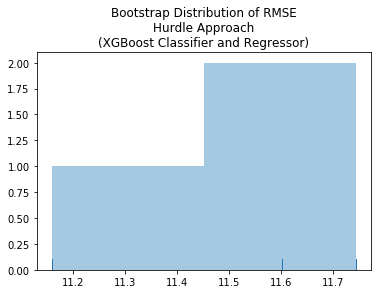

In [68]:
bootstrap_rmse_hurdle_xgbr = Parallel(n_jobs=-1, verbose = 1)(delayed(hurdle_rmse)(i) for i in inputs)

plot_bootstrap_histogram(bootstrap_rmse_hurdle_xgbr, 'Hurdle Approach\n(XGBoost Classifier and Regressor)')

# Boxplot of Bootstrap Distributions for All Methods

In [69]:
bootstrap_dict = {'Ridge Regression (Tuned Hyperparameters)' : bootstrap_rmse_ridge,
                  'Ridge Regression (Default Hyperparameters)': bootstrap_rmse_ridge_default,
                  'Multiple Linear Regression' : bootstrap_rmse_lr,
                  'LASSO Regression (Default Hyperparameters)': bootstrap_rmse_lasso_default,
                  'LASSO Regression (Tuned Hyperparameters)': bootstrap_rmse_lasso,
                  'Elastic Net Regression (Default Hyperparameters)': bootstrap_rmse_enet_default,
                  'Elastic Net Regression (Tuned Hyperparameters)': bootstrap_rmse_enet,
                  'CART (Default Hyperparameters)': bootstrap_rmse_dt_default,
                  'CART (Tuned Hyperparameters)': bootstrap_rmse_dt,
                  'Random Forest Regression (Default Hyperparameters)': bootstrap_rmse_rf_default,
                  'Random Forest Regression (Tuned Hyperparameters)': bootstrap_rmse_rf,
                  'Gradient Boosting Regression (Default Hyperparameters)': bootstrap_rmse_gb_default,
                  'Gradient Boosting Regression (Tuned Hyperparameters)': bootstrap_rmse_gb,
                  'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)': bootstrap_rmse_sgbr_default,
                  'Stochastic Gradient Boosting (Tuned Hyperparameters), sklearn)': bootstrap_rmse_sgb,
                  'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)': bootstrap_rmse_xgbr_default,
                  'Stochastic Gradient Boosting (Tuned Hyperparameters), xgboost)': bootstrap_rmse_xgbr,
                  'Hurdle Approach (xgboost classification and regression)': bootstrap_rmse_hurdle_xgbr}

In [70]:
ordered_dict_by_median = collections.OrderedDict(sorted(bootstrap_dict.items(), key=lambda t: np.median(t[1]), reverse = True))

In [71]:
bootstrap_distributions = pd.DataFrame(ordered_dict_by_median)

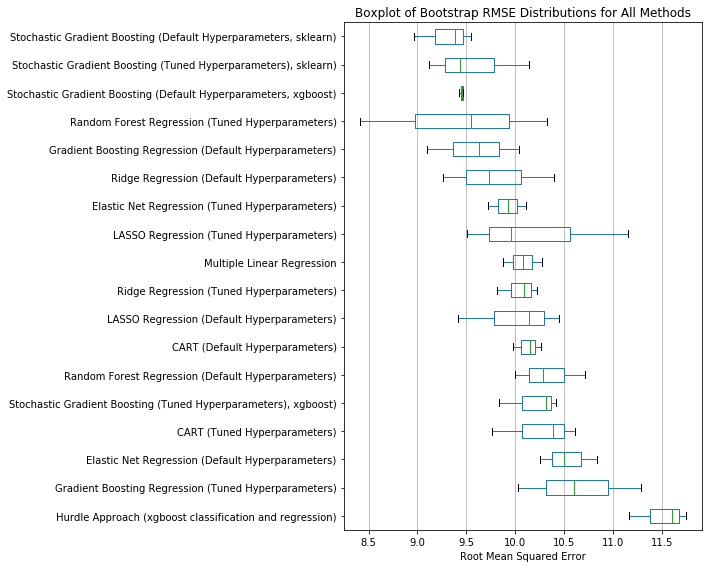

In [78]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 8))

_ = bootstrap_distributions.boxplot(vert = False, ax = ax)
_ = ax.yaxis.grid(False)
_ = ax.set_title('Boxplot of Bootstrap RMSE Distributions for All Methods')
_ = ax.set_xlabel('Root Mean Squared Error')
fig.tight_layout()
fig.savefig('images/boxplot_bootstrap_dist.png')
fig.show()

# Predict Opioid Overdose Mortality Rate for All Counties Using Best Model

In [79]:
y_pred_best_overall_model = sgb_randomized_neg_mse.best_estimator_.predict(X)

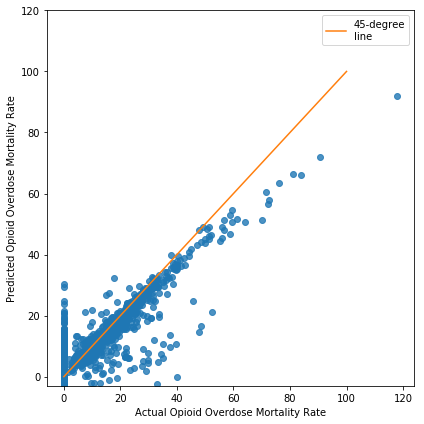

In [95]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = sns.regplot(y = y_pred_best_overall_model, x = y, fit_reg = False, ax = ax)
_ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
_ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
# _ = ax.set_title('Predicted vs Actual Opioid Overdose Mortality Rate')
_ = ax.plot([0, 100], [0, 100]) # 45 degree line
_ = ax.legend(['45-degree\nline'], frameon = True)
_ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/predicted_actual_regression.png')
fig.show()

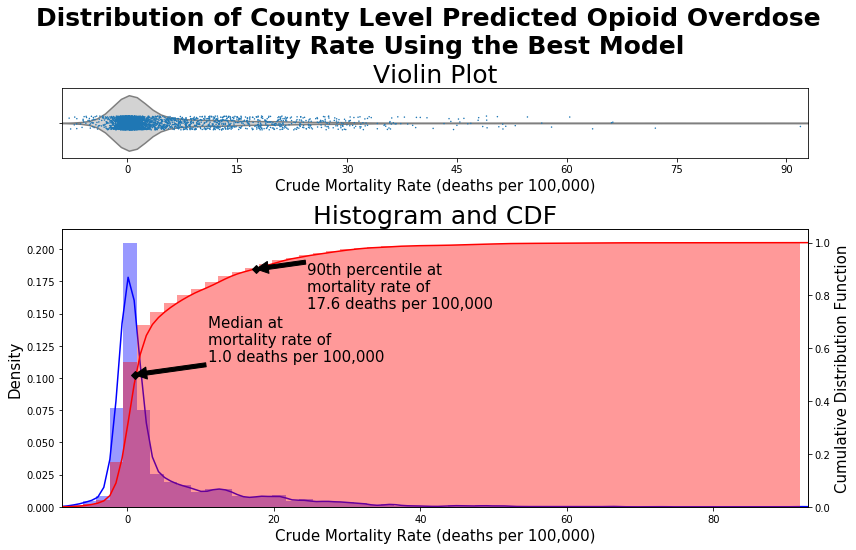

In [94]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(y_pred_best_overall_model)
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.2, .8)}, figsize = (12, 8))

# Add violinplot to first subplot
sns.violinplot(y_pred_best_overall_model, inner = None, color = 'lightgray', ax = ax_box)
sns.stripplot(y_pred_best_overall_model, size = 1.5, jitter = True, ax = ax_box)

# Set x-axis name for the violinplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((min(y_pred_best_overall_model) - 1, max(y_pred_best_overall_model) + 1))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for violinplot
ax_box.set_title("Violin Plot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(y_pred_best_overall_model, color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(y_pred_best_overall_model, 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(y_pred_best_overall_model, 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(round(median, 2)), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(y_pred_best_overall_model, 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((min(y_pred_best_overall_model) - 1, max(y_pred_best_overall_model) + 1))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Predicted Opioid Overdose\nMortality Rate Using the Best Model', 
           fontsize = 25, fontweight = 'bold')

# Adjust plot layout
f.tight_layout(rect = [0, 0.03, 1, 0.9])
f.savefig('images/distribution_y_pred.png')
f.show()

In [84]:
merged_data = pd.read_csv('merged_data.csv')

In [85]:
merged_data.shape

(2962, 39)

In [86]:
merged_data['Predicted Mortality Rate'] = y_pred_best_overall_model

In [87]:
merged_data['Predicted Mortality Rate'].describe()

count    2962.000000
mean        4.759093
std         9.359491
min        -7.950491
25%        -0.167098
50%         0.999505
75%         5.566737
max        91.899593
Name: Predicted Mortality Rate, dtype: float64

In [88]:
merged_data.head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,5_9_years_%,60_64_years__%,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,Predicted Mortality Rate
0,1001,55416.0,0.0,AL,129.6,14.0,440.0,455.0,12.096335,0.272440,...,6.620832,5.557962,4.805471,3.847264,2.869207,1.894760,1.311895,1.131442,Autauga,0.585299
1,1003,208563.0,8.6,AL,123.8,12.0,4646.0,2275.0,11.267825,0.823643,...,5.957912,6.897676,6.769178,5.161510,3.553363,2.250639,1.973504,1.097510,Baldwin,7.971293
2,1005,25965.0,0.0,AL,92.7,30.0,-490.0,2977.0,10.453899,-0.192167,...,6.204506,6.339303,6.192952,4.698633,3.158097,2.183709,1.783170,0.955132,Barbour,-0.042423
3,1007,22643.0,0.0,AL,97.2,20.0,72.0,2201.0,12.833562,0.885073,...,5.546968,5.895862,5.383562,3.833414,2.976637,1.815131,1.422073,1.157090,Bibb,-0.151975
4,1009,57704.0,0.0,AL,56.9,14.0,-28.0,489.0,11.723635,1.076838,...,6.476154,6.372175,6.094898,4.737973,3.292666,2.181824,1.679260,1.147234,Blount,-0.520096


In [89]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate', ascending=False).head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
989,Harrison,KY,118.0,91.899593
2819,Cabell,WV,90.6,72.092646
2843,Mingo,WV,81.1,66.286486
2863,Wayne,WV,83.9,66.108940
1162,Baltimore City,MD,76.1,63.526205


In [90]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head(20)

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
989,Harrison,KY,118.0,91.899593
2819,Cabell,WV,90.6,72.092646
2863,Wayne,WV,83.9,66.108940
2843,Mingo,WV,81.1,66.286486
1162,Baltimore City,MD,76.1,63.526205
1716,Rio Arriba,NM,72.4,57.920705
2815,Berkeley,WV,72.2,56.582398
724,Scott,IN,71.6,60.402328
1137,Washington,ME,70.0,51.253531
981,Grant,KY,64.2,50.525657


In [91]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
2750,Franklin City,VA,0.0,-7.950491
646,Wayne,IL,0.0,-7.745231
417,Grady,GA,0.0,-7.250891
476,Seminole,GA,0.0,-7.188610
1035,Owsley,KY,0.0,-6.924940


In [92]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
0,Autauga,AL,0.0,0.585299
1796,Bertie,NC,0.0,1.169105
1797,Bladen,NC,0.0,3.820913
1804,Caswell,NC,0.0,-0.282125
1806,Chatham,NC,0.0,-0.822376


In [93]:
# overall mse using best model
np.sqrt(np.mean((y - y_pred_best_overall_model)**2))

4.30884693297255